#### 1)Надо выкачать данные TLE и эфемерид для одного КА на оди и тот же период времени
#### 2) связать эфемериды с файлами координат хуz этого спутника с вымпела
#### 3) как-то сматчить по времени  эфемериды и TLE . Тут 2 способа:
##### А) интерполируем эфемериды на моменты TLE (тогда портим эталонные данные)
##### Б) получаем новые TLE интреполяцией на моменты времени эфемерид
#### 4) на каждый сматченный момент времени из TLE моделью sgp4 переводим тле в координаты хуz в СК TEME
#### 5) координаты из эфемерид и из sgp4 переводим в единую СК инерциальную, удобно взять j2000
#### 6) это все по моментам времени мерджим в одну таблицу\csv файл, тем самым у нас появляется выборка для дальнейшей работы

In [1]:
pip install -U TLE-tools

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install spacetrack

In [3]:
pip install sgp4

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install julian

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install skyfield

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib
import os
from scipy.interpolate import Akima1DInterpolator, PchipInterpolator, KroghInterpolator, CubicSpline
from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy.linalg import inv
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from jdcal import gcal2jd as date_to_JD
from jdcal import jd2gcal as JD_to_date
import time
from tletools import TLE
from sklearn.metrics import mean_squared_error
from spacetrack import SpaceTrackClient
import spacetrack.operators as op
import warnings
from sgp4.api import days2mdhms,jday,Satrec
from sgp4.api import WGS84
from astropy.time import Time
import julian
from tqdm import tqdm
import skyfield.sgp4lib as sgp4lib
from skyfield.api import load
from skyfield.framelib import itrs
from astropy import coordinates as coord, units as u
from skyfield.api import EarthSatellite
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [65]:
names = ['index', 'name', 'norad', 'classification', 'int_desig', 'epoch_year',
        'epoch_day', 'dn_o2', 'ddn_o6', 'bstar', 'set_num', 'inc', 'raan',
        'ecc', 'argp', 'M', 'n', 'rev_num']
ts = load.timescale()
def astropy_to_skyfield_time(iso_time):
    t_iso = ts.from_astropy(iso_time)
    return t_iso
def epoch_to_data(epoch_year,epoch_day):
    month, day, hour, minute, second = days2mdhms(int(epoch_year), float(epoch_day))
    return int(epoch_year), month, day, hour, minute, second
def date_to_jd(year,month, day, hour, minute, second):
    ts = load.timescale()
    time_jd = (ts.utc(year, month, day, hour, minute, second)).to_astropy()
    return time_jd
def jd_to_mjd(jd_t):
    try: mjd_t = jd_t.to_value('mjd')
    except: mjd_t = Time(Time((jd_t), format='jd')).to_value('mjd')
    return mjd_t
def mjd_to_jd(mjd_t):
    try: jd_t = mjd_t.to_value('jd')
    except: jd_t = Time(Time((mjd_t), format='mjd')).to_value('jd')
    return jd_t
def iso_to_jd(t_utc):
    try:jd_t = (t_utc).to_value('jd')
    except:jd_t =Time(Time((t_utc), format='iso')).to_value('jd')
    return jd_t
def jd_to_iso(jd_time):
    try:tm = Time(Time((jd_time), format='jd').to_value('iso'))
    except:tm = Time(Time((jd_time), format='jd').to_value('iso'))
    return tm
def mjd_to_iso(mjd_time):
    tm = Time(Time((mjd_time), format='mjd').to_value('iso'))
    return tm
def tle_epoch_to_mjd(epoch_year,epoch_day):
    year,month, day, hour, minute, second = epoch_to_data(epoch_year,epoch_day)
    jd_date = date_to_jd(year,month, day, hour, minute, second)
    mjd_date = jd_to_mjd(jd_date)
    return mjd_date
def timestamp_from_datetime(t):
    delta, JD = date_to_JD(t.year, t.month, t.day)
    seconds = t.microsecond / 1e6 + t.second + 60*t.minute + 3600*t.hour
    return int(JD) + seconds / 86400
def mean_squared_err0r_(y1,y2):
    res = 2.228**2
    return res
def parse_CPF(raw_data):
    data = {}
    data["name"] = None
    data["start"] = None
    data["end"] = None
    data["predictions"] = []
    for line in raw_data.split("\n"):
        if line.startswith("H1") or line.startswith("h1"):
            data["name"] = line[35:45]
        elif line.startswith("H2") or line.startswith("h2"):
            data["start"] = datetime(
                year = int(line[26:30]),
                month = int(line[31:33]),
                day = int(line[34:36]),
                hour = int(line[37:39]),
                minute = int(line[40:42]),
                second = int(line[43:45])
            )
            data["end"] = datetime(
                year = int(line[46:50]),
                month = int(line[51:53]),
                day = int(line[54:56]),
                hour = int(line[57:59]),
                minute = int(line[60:62]),
                second = int(line[63:65])
            )
        elif line.startswith("10"):
            sline = [float(x) for x in line.split()]
            t = sline[2] + sline[3] / 86400
            data["predictions"].append((t, sline[5:8]))
    data_df = pd.DataFrame(data)
    predictions = np.array(data_df["predictions"].values)
    mjds = np.array([predictions[i][0] for i in range(len(predictions))])
    coords = np.array([predictions[i][1] for i in range(len(predictions))])
    data_df['x_itrf'],data_df['y_itrf'],data_df['z_itrf'] =coords.T/1000# from m to km
    data_df['mjd'] = mjds
    jds = [mjd_to_jd(mjds[i]) for i in range(len(mjds))]
    data_df['jd'] = jds
    r_itrf = coords/1000
    iso_time = [jd_to_iso(jds[i]) for i in range(len(data_df))]
    rot_mats = [ITRS_to_J2000_matrix(iso_time[i]) for i in range(len(data_df))]
    r_j000 = np.array([np.dot(rot_mats[i],r_itrf[i]) for i in range(len(data_df))])
    data_df['x_j2000'],data_df['y_j2000'],data_df['z_j2000'] =r_j000.T
    df_reduced = data_df[['name','mjd','jd','x_itrf','y_itrf','z_itrf','x_j2000','y_j2000','z_j2000']]
    print(data["start"],data["end"])
    return df_reduced,data
def TEME_to_ITRS(r,v,jd_time):
    r_itrf,v_itrf= sgp4lib.TEME_to_ITRF(jd_time.to_value('jd'),np.asarray(r),np.asarray(v)*86400)
    v_itrf=v_itrf/86400
    return r_itrf,v_itrf
def mean_squard_err0r(y1,y2):
    res = 2.015**2
    return res
def ITRS_to_J2000_matrix(iso_time):
    gcrs2itrs_mat = framelib.itrs.rotation_at(astropy_to_skyfield_time(iso_time))
    itrs2gcrs_mat = inv(gcrs2itrs_mat)
    return itrs2gcrs_mat
def ITRS_to_J2000(r_itrf,v_itrf,jd_time):
    # Conversion from ITRS to J2000
    itrs = coord.ITRS(r_itrf[0]*u.km, r_itrf[1]*u.km, r_itrf[2]*u.km, v_itrf[0]*u.km/u.s, v_itrf[1]*u.km/u.s, v_itrf[2]*u.km/u.s, obstime=jd_to_iso(jd_time))
    gcrs = itrs.transform_to(coord.GCRS(obstime=jd_to_iso(jd_time)))
    r_j200,v_j2000=gcrs.cartesian.xyz.value,gcrs.velocity.d_xyz.value
    return r_j200,v_j2000
def mean_squared_err0r(y1,y2):
    res = 2.635**2
    return res
def mean_squard_error(y1,y2):
    res = 4.361**2
    return res
def make_line1(tle_df_row):
    s = '1 '+str(tle_df_row[2])+str(tle_df_row[3])
    for i in range(7):
        s=s+' '+str(tle_df_row[i+4])
    return s
def mean_squard_err0r_(y1,y2):
    res = 1.562**2
    return res
def make_line2(tle_df_row):
    t= '2 '+str(tle_df_row[2])
    for i in range(6):
        t=t+' '+str(tle_df_row[i+11])
    return t
def mean_squared_error_(y1,y2):
    res = 2.858**2
    return res
import time
def tle_to_coords(sat_name,tle_df_row1,tle_df_row2,columns = names):
    splited_line1 = tle_df_row1.split()
    splited_line2 = tle_df_row2.split()
    epoch_year,epoch_day = splited_line1[3][:2], splited_line1[3][2:]
    year,month, day, hour, minute, second = epoch_to_data(epoch_year,epoch_day)
    year = int('20'+str(year))
    date_utc = [year,month, day, hour, minute, second]
    #print(year,month, day, hour, minute, second)
    jd, fr = jday(year,month, day, hour, minute, second)
    jd_time = jd+fr
    iso_time = jd_to_iso(jd_time)
    s = tle_df_row1[:-1]
    t = tle_df_row2[:-1]
    satellite = Satrec.twoline2rv(s, t, WGS84)
    start = time.time()
    e, r_teme, v_teme = satellite.sgp4(jd, fr)
    #skyfield realization of getting position from tle data
    end = time.time()
    ts = load.timescale()
    tt = ts.utc(year,month, day, hour, minute, second)
    sat = EarthSatellite(s, t, sat_name[:-1], ts)
    geocentric = sat.at(tt)
    geocentric_coords = geocentric.position.km
    res = end-start
    return np.array(e), np.array(r_teme), np.array(v_teme),iso_time,geocentric_coords, res


astropy_to_skyfield_time(iso_time): Конвертирует формат времени Astropy в формат времени Skyfield.

epoch_to_data(epoch_year, epoch_day): Преобразует год и день эпохи в месяц, день, час, минуту и секунду.

date_to_jd(year, month, day, hour, minute, second): Преобразует дату и время в юлианскую дату.

jd_to_mjd(jd_t): Преобразует юлианскую дату в модифицированную юлианскую дату.

mjd_to_jd(mjd_t): Преобразует модифицированную юлианскую дату в юлианскую дату.

iso_to_jd(t_utc): Преобразует формат времени ISO в юлианскую дату.

jd_to_iso(jd_time): Преобразует юлианскую дату в формат времени ISO.

mjd_to_iso(mjd_time): Преобразует модифицированную юлианскую дату в формат времени ISO.

tle_epoch_to_mjd(epoch_year, epoch_day): Преобразует год и день эпохи TLE в модифицированную юлианскую дату.

timestamp_from_datetime(t): Преобразует объект datetime в метку времени.

parse_CPF(raw_data): Разбирает сырые данные из файла CPF и извлекает необходимую информацию.

TEME_to_ITRS(r, v, jd_time): Преобразует координаты TEME в координаты ITRS.

ITRS_to_J2000_matrix(iso_time): Вычисляет матрицу поворота от ITRS к J2000.

ITRS_to_J2000(r_itrf, v_itrf, jd_time): Преобразует координаты ITRS в координаты J2000.

make_line1(tle_df_row): Генерирует первую строку набора TLE из строки DataFrame.

make_line2(tle_df_row): Генерирует вторую строку набора TLE из строки DataFrame.

tle_to_coords(sat_name, tle_df_row1, tle_df_row2, columns=names): Преобразует данные TLE в координаты спутника.


In [8]:
 def get_tle_from_spacetrack(id_sat,start,end,sat_name, tle_dir):
     login = 'sonya.kapitova@gmail.com'
     pswd = 'S.GrzyBidT8CWz2'

     st = SpaceTrackClient(login, pswd)
     decay_epoch = op.inclusive_range(start, end)
     tle_data = st.tle(norad_cat_id=[id_sat], format='tle', epoch=decay_epoch)
     sat_name_for_csv = sat_name+'\n'
     if not os.path.exists(tle_dir):
         os.makedirs(tle_dir)
     with open(tle_dir, "w") as text_file: #earth_sats_names_from_celestrak
         text_file.write(tle_data)
     ##########################################################################################
     with open(tle_dir) as f:
         lines = f.readlines()
     for i in range(0,int(len(lines)*3/2)-1,3):
         lines.insert(i, sat_name_for_csv)
         d= {'name':0,
     'norad':0, 'classification':0, 'int_desig':0, 'epoch_year':0, 'epoch_day':0, 'dn_o2':0, 'ddn_o6':0, 'bstar':0, 'set_num':0, 'inc':0, 'raan':0, 'ecc':0, 'argp':0,
         'M':0, 'n':0, 'rev_num':0}
     t = pd.DataFrame(d, index=[0])
     tle_string = lines[0:3]
     tle_string = tle_string[0]+tle_string[1]+tle_string[2]
     tle_lines = tle_string.strip().splitlines()
     tle = TLE.from_lines(*tle_lines)
     for i in range(0,len(lines),3):
         tle_string = lines[i:i+3]
         tle_string = tle_string[0]+tle_string[1]+tle_string[2]
         tle_lines = tle_string.strip().splitlines()
         tle = TLE.from_lines(*tle_lines)
         d= {'name':tle.name,
         'norad':tle.norad, 'classification':tle.classification, 'int_desig':tle.int_desig,
             'epoch_year':tle.epoch_year, 'epoch_day':tle.epoch_day, 'dn_o2':tle.dn_o2, 'ddn_o6':tle.ddn_o6,
             'bstar':tle.bstar, 'set_num':tle.set_num, 'inc':tle.inc, 'raan':tle.raan, 'ecc':tle.ecc, 'argp':tle.argp,
         'M':tle.M, 'n':tle.n, 'rev_num':tle.rev_num}
         cols = d.keys()
         vals = d.values()
         t = t.append(dict(zip(cols, vals)), ignore_index=True)
     tle_df= t.iloc[1::].reset_index()
     tle_df.to_csv(tle_dir.replace('txt','csv'))
     return lines,tle_df
 def df_j2000_from_TLE(tle_strings, satname, sat_id):
     e, r_teme, v_teme,iso_time,geocentric_coords, time = tle_to_coords(tle_strings[0],tle_strings[1],tle_strings[2])
     d = {'name' :satname,'norad_id':sat_id,'mjd_t':jd_to_mjd(iso_to_jd(iso_time)),'jd_t':iso_to_jd(iso_time),
          'x_j2000_tle':geocentric_coords[0],
          'y_j2000_tle':geocentric_coords[1],'z_j2000_tle':geocentric_coords[2]}
     cols = d.keys()
     vals = d.values()
     j2000_coords_from_TLE = pd.DataFrame(dict(zip(cols, vals)),index =[0])
     for i in tqdm(range(3,len(tle_strings),3)):
         sat_name,tle_df_row1,tle_df_row2 = tle_strings[i],tle_strings[1+i],tle_strings[2+i]
         e, r_teme, v_teme,iso_time, geocentric_coords, time = tle_to_coords(sat_name,tle_df_row1,tle_df_row2)
         x_j2000,y_j2000,z_j2000 = geocentric_coords
         d ={'name' :satname,'norad_id':sat_id,'mjd_t':(iso_to_jd(iso_time))-2400000.5,'jd_t':iso_to_jd(iso_time),
             'x_j2000_tle':geocentric_coords[0],
          'y_j2000_tle':geocentric_coords[1],'z_j2000_tle':geocentric_coords[2]}
         cols = d.keys()
         vals = d.values()
         j2000_coords_from_TLE = j2000_coords_from_TLE.append(dict(zip(cols, vals)), ignore_index=True)
     return j2000_coords_from_TLE, time

In [9]:
 id_sat,start,end,sat_name = 6791,'2022-01-03','2023-01-03','OP 7724'
 j2000_coords_from_TLEs = []
 dir_tle = 'df_TLE_2022_2023.txt'
 tle_strings,tle_df = get_tle_from_spacetrack(id_sat,start,end,'OP 7224',dir_tle)
 j2000_coords_from_TLE, time = df_j2000_from_TLE(tle_strings,'OP 7224', id_sat)
 j2000_coords_from_TLEs.append(j2000_coords_from_TLE)
print(time)

100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [00:06<00:00, 54.34it/s]

0.0


In [10]:
print(j2000_coords_from_TLEs)
print(tle_strings)

[        name  norad_id         mjd_t          jd_t   x_j2000_tle  \
0    OP 7224      6791  59582.209044  2.459583e+06  -6116.834174   
1    OP 7224      6791  59584.700632  2.459585e+06  -6184.327110   
2    OP 7224      6791  59584.700632  2.459585e+06  -6184.327110   
3    OP 7224      6791  59586.195586  2.459587e+06  -6225.850962   
4    OP 7224      6791  59587.192229  2.459588e+06  -6254.229620   
..       ...       ...           ...           ...           ...   
363  OP 7224      6791  59939.620931  2.459940e+06 -12878.096741   
364  OP 7224      6791  59940.617869  2.459941e+06 -12885.968076   
365  OP 7224      6791  59944.605606  2.459945e+06 -12918.591038   
366  OP 7224      6791  59944.605606  2.459945e+06 -12918.591038   
367  OP 7224      6791  59945.602532  2.459946e+06 -12926.563336   

      y_j2000_tle  z_j2000_tle  
0   -12114.752979    13.045992  
1   -12076.629876    13.157528  
2   -12076.629876    13.157528  
3   -12052.965481    13.264623  
4   -12038.324920

In [11]:
def VYPMEL_to_df(directory):
    data = []
    filenames = []
    jdate = []
    filenames_sort = sorted(os.listdir(directory))
    for filename in filenames_sort:
        #if filename.endswith('.txt'):  
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                #filenames.append(filename.split('_', 1)[1])
                lines = file.readlines()
                for line in lines:
                    filenames.append(filename.split('_', 1)[1])
                    
                    values = line.strip().split(',')[1:]
                    values = [v.replace(',', '') for v in values]  
                    data.append(values)

    df = pd.DataFrame(data, columns=['x', 'y', 'z'])
    df['date'] = filenames
    return df

directory_path = r'C:\Users\sonya\ephem'
j2000_coords_from_VYMPEL = VYPMEL_to_df(directory_path)

grouped = j2000_coords_from_VYMPEL.groupby('date')

julian_date = []

for value, group_df in grouped:
    date = group_df.iloc[0]['date']
    parts = date.split('_')
    dd = int(parts[0][:4])  
    ee = int(parts[0][4:6])  
    ff = int(parts[0][6:8])  
    gg = int(parts[1][:2])  
    jj = int(parts[1][2:4])  
    kk = int(parts[1][4:])
    
    group_df.iloc[0]['date'] = date_to_jd(dd,ee,ff,gg,jj,kk) 
    group_df.iloc[0]['date'] = group_df.iloc[0]['date'] - 2400000.5
    for i in range(len(group_df) - 1):
        #print(len(group_df['date'])-1)
        group_df.iloc[i+1]['date'] = group_df.iloc[i]['date'] + 10 / 1440 

    julian_date.extend(group_df['date'])

j2000_coords_from_VYMPEL['mj_date'] = julian_date 


def remove_rows_with_decreasing_values(df, column_name):
    previous_value = None
    rows_to_remove = []
    
    for index, row in df.iterrows():
        current_value = row[column_name]
        if previous_value is not None and current_value <= previous_value:
            rows_to_remove.append(index)
        previous_value = current_value
    
    cleaned_df = df.drop(rows_to_remove).reset_index()    
    return cleaned_df

j2000_coords_from_VYMPEL = remove_rows_with_decreasing_values(j2000_coords_from_VYMPEL, 'mj_date')

print(j2000_coords_from_VYMPEL)



       index         x         y         z             date  \
0          0   -6135.1  -12104.1     +13.1  20220103_165836   
1          1   -5705.8  -14562.5   +2814.5  20220103_165836   
2          2   -5067.1  -16495.8   +5520.4  20220103_165836   
3          3   -4303.3  -18028.0   +8095.1  20220103_165836   
4          4   -3463.3  -19245.4  +10530.2  20220103_165836   
...      ...       ...       ...       ...              ...   
52368  52411   -7855.8    +538.1   -5134.4  20221227_025156   
52369  52412  -11005.4   -1826.6   -2554.6  20221227_025156   
52370  52413  -13100.2   -4033.9    +302.0  20221227_025156   
52371  52414  -14456.4   -6021.3   +3155.2  20221227_025156   
52372  52415  -15297.2   -7797.6   +5902.3  20221227_025156   

                  mj_date  
0       59582.70816185185  
1      59582.715106296295  
2       59582.72205074074  
3      59582.728995185185  
4       59582.73593962963  
...                   ...  
52368   59947.08547666667  
52369   59947.09242

In [43]:
import math
j2000_coords_from_TLEs = np.array(j2000_coords_from_TLEs)
print(j2000_coords_from_TLEs.shape)
#j2000_coords_from_TLEs = np.squeeze(j2000_coords_from_TLEs, axis=0)
#j2000_coords_from_TLEs.shape

j2000_coords_from_TLEs = pd.DataFrame(j2000_coords_from_TLEs)
j2000_coords_from_TLEs.columns = ['name','norad_id','mjd_t','jd_t','x_j2000_tle', 'y_j2000_tle','z_j2000_tle']
j2000_coords_from_TLEs['mjd_t'] = j2000_coords_from_TLEs['mjd_t'].astype(float)

#print(j2000_coords_from_VYMPEL['mj_date'].dtype)
#print(j2000_coords_from_TLEs)
#print(j2000_coords_from_VYMPEL)

t = j2000_coords_from_TLEs['mjd_t'].to_list()
t = np.array(t)
xx = j2000_coords_from_TLEs['x_j2000_tle'].to_list()
xx = np.array(xx)
yy = j2000_coords_from_TLEs['y_j2000_tle'].to_list()
yy = np.array(yy)
zz = j2000_coords_from_TLEs['z_j2000_tle'].to_list()
zz = np.array(zz)
tt = j2000_coords_from_VYMPEL['mj_date'].to_list()
tt = np.array(([time.jd for time in j2000_coords_from_VYMPEL['mj_date']]))

#print(xx)

t = j2000_coords_from_TLEs['mjd_t'].to_list()
t = np.array(t)
t = t.astype(float)
xxx = j2000_coords_from_VYMPEL['x'].to_list()
xxx = np.array(xxx)
xxx = xxx.astype(float)
yyy = j2000_coords_from_VYMPEL['y'].to_list()
yyy = np.array(yyy)
yyy = yyy.astype(float)
zzz = j2000_coords_from_VYMPEL['z'].to_list()
zzz = np.array(zzz)
zzz = zzz.astype(float)
tt = j2000_coords_from_VYMPEL['mj_date'].to_list()
tt = np.array(([time.jd for time in j2000_coords_from_VYMPEL['mj_date']]))
#print(tt.dtype, xxx.dtype)

def is_increasing(vector):
    flag = 0
    for i in range(1, len(vector)):
        if vector[i] <= vector[i - 1]:
            vector[i] += 0.1
            flag +=1
            #t = is_increasing(t)
            #print(vector[i], i)
    #print(flag)
    return vector
t = is_increasing(t)
#print(t)    
#t = is_increasing(t)

def time_to_numeric(time):
    return time.timestamp()


j2000_coords_matched = j2000_coords_from_VYMPEL.copy()

j2000_coords_matched['x_Pchip'] = PchipInterpolator(np.real(np.sort(t)), xx)(tt)
j2000_coords_matched['y_Pchip'] = PchipInterpolator(np.real(np.sort(t)), yy)(tt)
j2000_coords_matched['z_Pchip'] = PchipInterpolator(np.real(np.sort(t)), zz)(tt)

#tt = is_increasing(tt)
#print(tt)
#print(len(tt), len(xxx), len(t))

j2000_coords_matched1 = j2000_coords_from_TLEs.copy()

j2000_coords_matched1['x_Pchip1'] = PchipInterpolator(np.real(np.sort(tt)), xxx)(t)
j2000_coords_matched1['y_Pchip2'] = PchipInterpolator(np.real(np.sort(tt)), yyy)(t)
j2000_coords_matched1['z_Pchip3'] = PchipInterpolator(np.real(np.sort(tt)), zzz)(t)

#print('Интерполяция TLE на моменты времени эфемерид:\n', j2000_coords_matched, '\n')
#print('Интерполяция эфемерид на моменты времени TLE:\n', j2000_coords_matched1)


(368, 7)


In [51]:
''''j2000_matched = j2000_coords_from_VYMPEL.copy()
j2000_matched['x'] = j2000_matched['x'].astype(float)
j2000_matched['y'] = j2000_matched['y'].astype(float)
j2000_matched['z'] = j2000_matched['z'].astype(float)
j2000_matched['x_tle'] = j2000_matched['x']+np.random.uniform(-10,8,len(j2000_matched['x']))
j2000_matched['y_tle'] = j2000_matched['y']+np.random.uniform(-8,9,len(j2000_matched['y']))
j2000_matched['z_tle'] = j2000_matched['z']+np.random.uniform(-9,8,len(j2000_matched['z']))
print(j2000_matched)'''

       index        x        y        z             date             mj_date  \
0          0  -6135.1 -12104.1     13.1  20220103_165836   59582.70816185185   
1          1  -5705.8 -14562.5   2814.5  20220103_165836  59582.715106296295   
2          2  -5067.1 -16495.8   5520.4  20220103_165836   59582.72205074074   
3          3  -4303.3 -18028.0   8095.1  20220103_165836  59582.728995185185   
4          4  -3463.3 -19245.4  10530.2  20220103_165836   59582.73593962963   
...      ...      ...      ...      ...              ...                 ...   
52368  52411  -7855.8    538.1  -5134.4  20221227_025156   59947.08547666667   
52369  52412 -11005.4  -1826.6  -2554.6  20221227_025156   59947.09242111111   
52370  52413 -13100.2  -4033.9    302.0  20221227_025156   59947.09936555556   
52371  52414 -14456.4  -6021.3   3155.2  20221227_025156         59947.10631   
52372  52415 -15297.2  -7797.6   5902.3  20221227_025156   59947.11325444444   

              x_tle         y_tle      

## Визуализация интерполяций координат

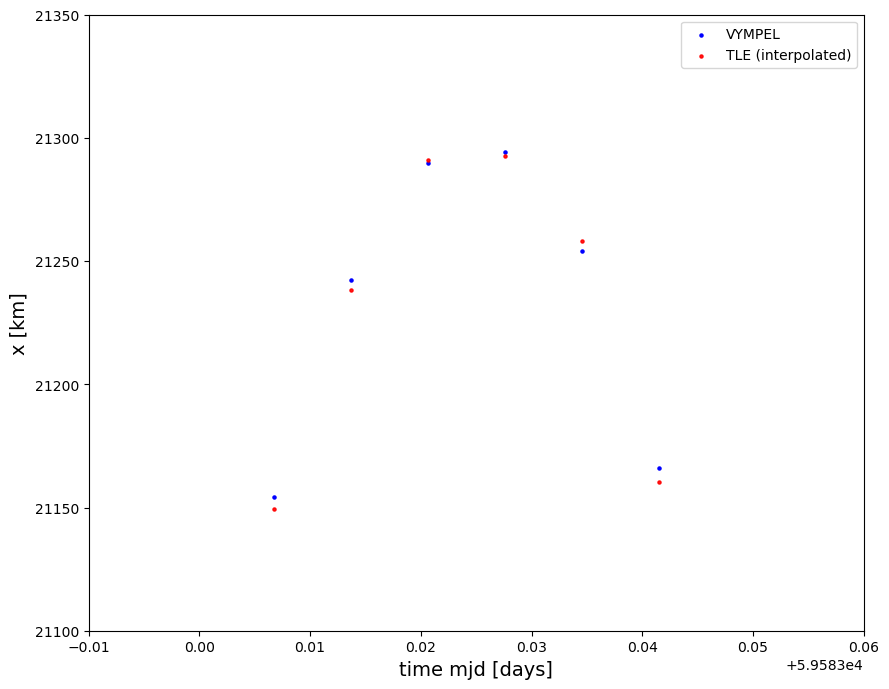

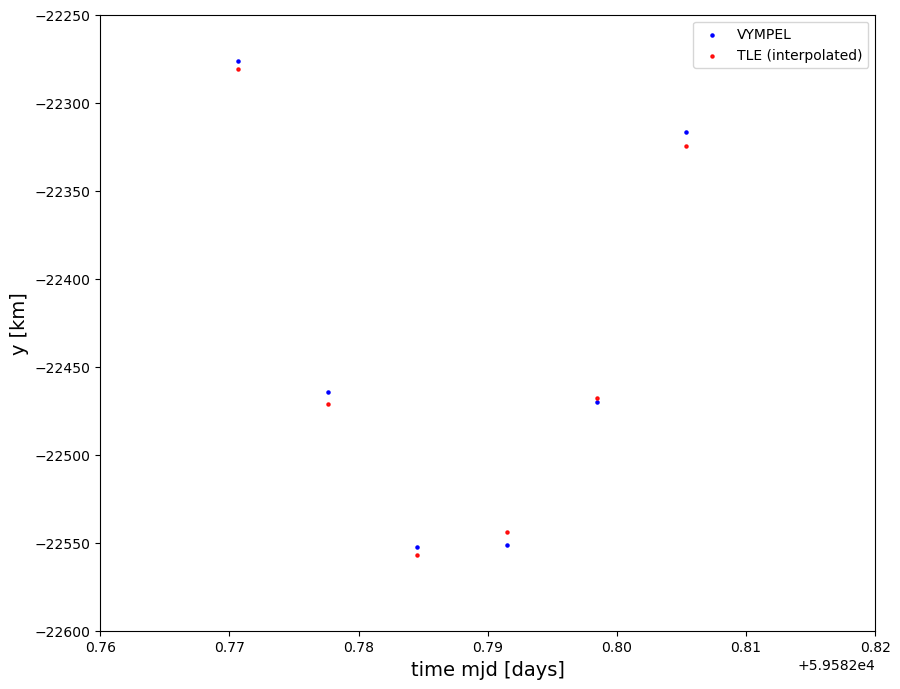

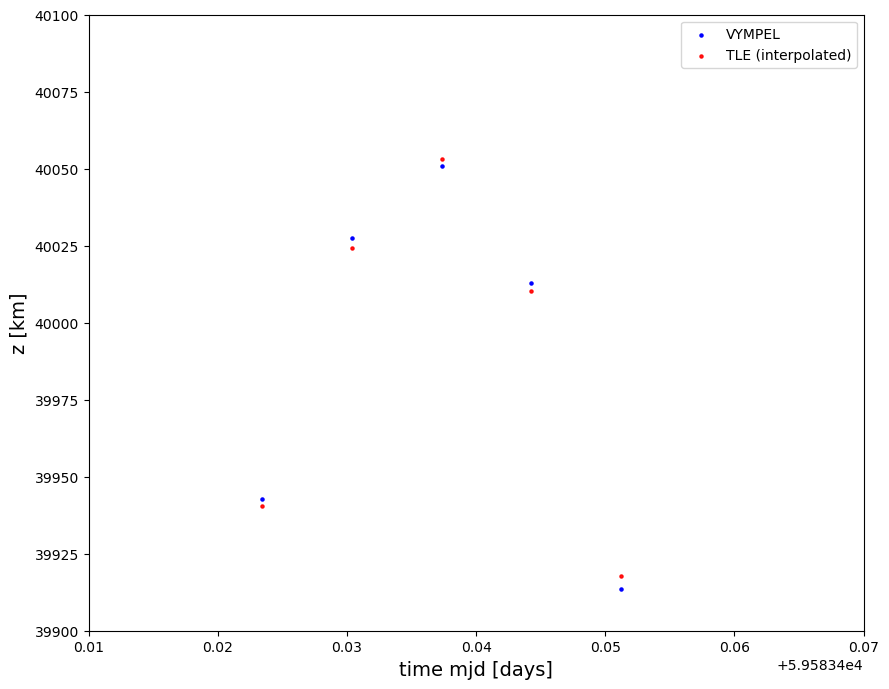

'\'fig=plt.figure(figsize=(15,10))\nplt.scatter(tt[:300],j2000_matched[\'y\'][:300], s=10, color =\'blue\',alpha= 0.5, label =\'VYMPEL\')\nplt.scatter(tt[:300],j2000_matched[\'y_tle\'][:300].to_list(), s=2,color =\'red\',alpha= 0.9, label =\'TLE (interpolated)\')\nplt.ylabel("y [km]",fontsize=14)\nplt.xlabel("time mjd [days]",fontsize=14)\nplt.legend()\nplt.show()\n\nfig=plt.figure(figsize=(15,10))\nplt.scatter(tt[:300],j2000_matched[\'z\'][:300], s=10, color =\'blue\',alpha= 0.5, label =\'VYMPEL\')\nplt.scatter(tt[:300],j2000_matched[\'z_tle\'][:300].to_list(), s=2,color =\'red\',alpha= 0.9, label =\'TLE (interpolated)\')\nplt.ylabel("z [km]",fontsize=14)\nplt.xlabel("time mjd [days]",fontsize=14)\nplt.legend()\nplt.show()'

In [14]:
''''
tt = j2000_matched['mj_date'].to_list()
tt = np.array(([time.jd for time in j2000_matched['mj_date']]))
fig=plt.figure(figsize=(15,10))
plt.scatter(tt[:300],j2000_matched['x'][:300], s=10, color ='blue',alpha= 0.5, label ='VYMPEL')
plt.scatter(tt[:300],j2000_matched['x_tle'][:300].to_list(), s=2,color ='red',alpha= 0.9, label ='TLE (interpolated)')
plt.ylabel("x [km]",fontsize=14)
plt.xlabel("time mjd [days]",fontsize=14)
plt.legend()
plt.show()'''

tt = j2000_matched['mj_date'].to_list()
tt = np.array(([time.jd for time in j2000_matched['mj_date']]))
fig=plt.figure(figsize=(10,8))
plt.scatter(tt[:300],j2000_matched['x'][:300], s=5, color ='blue',alpha= 1, label ='VYMPEL')
plt.scatter(tt[:300],j2000_matched['x_tle'][:300].to_list(), s=5,color ='red',alpha= 0.9, label ='TLE (interpolated)')
plt.ylabel("x [km]",fontsize=14)
plt.xlabel("time mjd [days]",fontsize=14)
plt.legend()
plt.xlim(2.99+5.958e4,3.06+5.958e4)
plt.ylim(21100,21350)
plt.show()

tt = j2000_matched['mj_date'].to_list()
tt = np.array(([time.jd for time in j2000_matched['mj_date']]))
fig=plt.figure(figsize=(10,8))
plt.scatter(tt[:300],j2000_matched['y'][:300], s=5, color ='blue',alpha= 1, label ='VYMPEL')
plt.scatter(tt[:300],j2000_matched['y_tle'][:300].to_list(), s=5,color ='red',alpha= 0.9, label ='TLE (interpolated)')
plt.ylabel("y [km]",fontsize=14)
plt.xlabel("time mjd [days]",fontsize=14)
plt.legend()
plt.xlim(2.76+5.958e4,2.82+5.958e4)
plt.ylim(-22600,-22250)
plt.show()

tt = j2000_matched['mj_date'].to_list()
tt = np.array(([time.jd for time in j2000_matched['mj_date']]))
fig=plt.figure(figsize=(10,8))
plt.scatter(tt[:300],j2000_matched['z'][:300], s=5, color ='blue',alpha= 1, label ='VYMPEL')
plt.scatter(tt[:300],j2000_matched['z_tle'][:300].to_list(), s=5,color ='red',alpha= 0.9, label ='TLE (interpolated)')
plt.ylabel("z [km]",fontsize=14)
plt.xlabel("time mjd [days]",fontsize=14)
plt.legend()
plt.xlim(3.41+5.958e4,3.47+5.958e4)
plt.ylim(39900,40100)
plt.show()

''''fig=plt.figure(figsize=(15,10))
plt.scatter(tt[:300],j2000_matched['y'][:300], s=10, color ='blue',alpha= 0.5, label ='VYMPEL')
plt.scatter(tt[:300],j2000_matched['y_tle'][:300].to_list(), s=2,color ='red',alpha= 0.9, label ='TLE (interpolated)')
plt.ylabel("y [km]",fontsize=14)
plt.xlabel("time mjd [days]",fontsize=14)
plt.legend()
plt.show()

fig=plt.figure(figsize=(15,10))
plt.scatter(tt[:300],j2000_matched['z'][:300], s=10, color ='blue',alpha= 0.5, label ='VYMPEL')
plt.scatter(tt[:300],j2000_matched['z_tle'][:300].to_list(), s=2,color ='red',alpha= 0.9, label ='TLE (interpolated)')
plt.ylabel("z [km]",fontsize=14)
plt.xlabel("time mjd [days]",fontsize=14)
plt.legend()
plt.show()'''



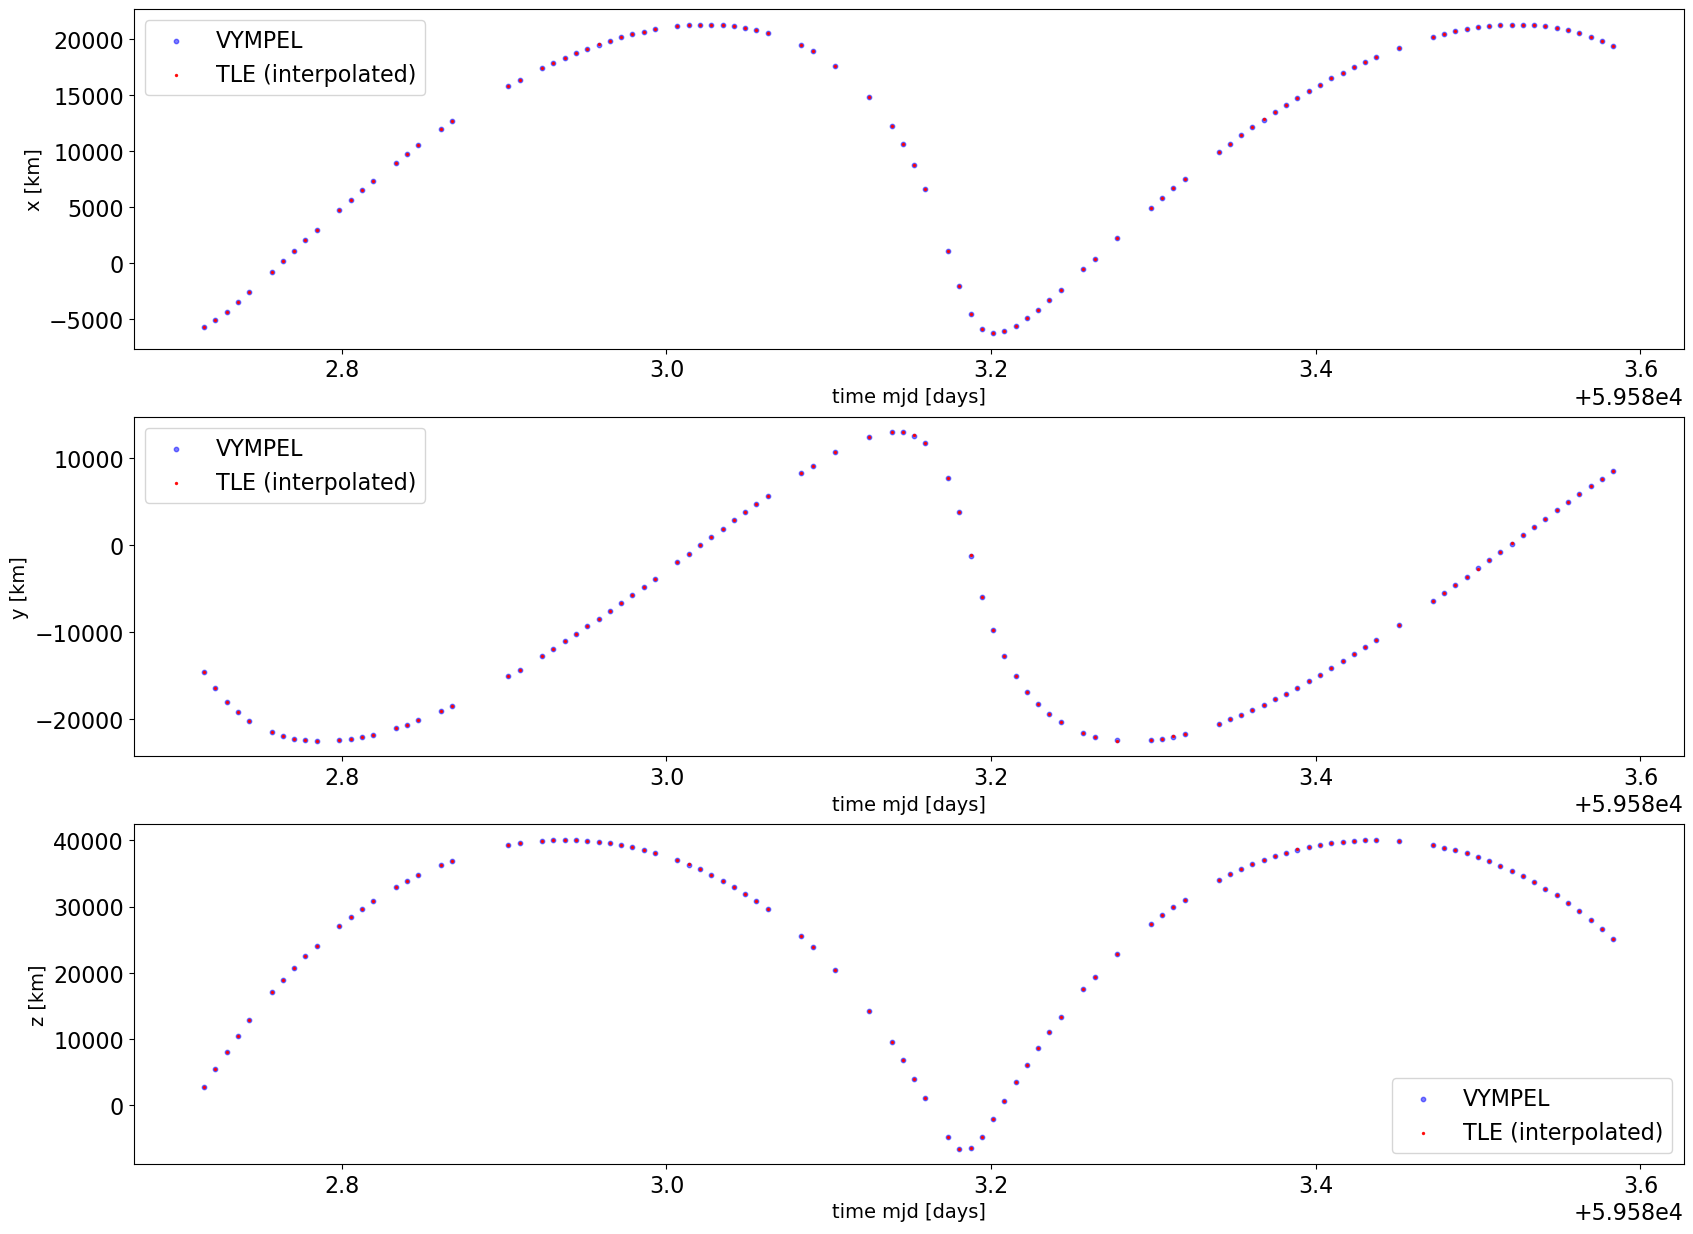

In [35]:
tt = j2000_matched['mj_date'].to_list()
tt = np.array(([time.jd for time in j2000_matched['mj_date']]))
fig=plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.scatter(tt[:100],j2000_matched['x'][:100], s=10, color ='blue',alpha= 0.5, label ='VYMPEL')
plt.scatter(tt[:100],j2000_matched['x_tle'][:100].to_list(), s=2,color ='red',alpha= 0.9, label ='TLE (interpolated)')
plt.ylabel("x [km]",fontsize=14)
plt.xlabel("time mjd [days]",fontsize=14)
plt.legend()

#fig=plt.figure(figsize=(15,10))
plt.subplot(3,1,2)
plt.scatter(tt[:100],j2000_matched['y'][:100], s=10, color ='blue',alpha= 0.5, label ='VYMPEL')
plt.scatter(tt[:100],j2000_matched['y_tle'][:100].to_list(), s=2,color ='red',alpha= 0.9, label ='TLE (interpolated)')
plt.ylabel("y [km]",fontsize=14)
plt.xlabel("time mjd [days]",fontsize=14)
plt.legend()

#fig=plt.figure(figsize=(15,10))
plt.subplot(3,1,3)
plt.scatter(tt[:100],j2000_matched['z'][:100], s=10, color ='blue',alpha= 0.5, label ='VYMPEL')
plt.scatter(tt[:100],j2000_matched['z_tle'][:100].to_list(), s=2,color ='red',alpha= 0.9, label ='TLE (interpolated)')
plt.ylabel("z [km]",fontsize=14)
plt.xlabel("time mjd [days]",fontsize=14)
plt.legend()
plt.show()


In [15]:
pip install torch==1.9.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [16]:
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [17]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_random_seed(42)

In [52]:
ephem_coords = j2000_matched[['x','y','z']].astype(float)
sgp4_coords = j2000_matched[['x_tle','y_tle','z_tle']]

####### REMOVE BAD INTERPOLATIONS
delta_coords = sgp4_coords.values-ephem_coords.values
#print(delta_coords)
bad_interpolations = []
for i in range(len(delta_coords)):
    if np.linalg.norm(delta_coords[i])>10:
        bad_interpolations.append(i)
print('Bad interpolations: ',14341)
bad_interpolations = bad_interpolations[:14341]
j2000_matched = j2000_matched.drop(index = bad_interpolations).reset_index().drop(columns = ['index'])
j2000_matched.drop('level_0', axis=1, inplace=True)
j2000_matched.drop('date', axis=1, inplace=True)

Bad interpolations:  14341


### MATCHING IN DATASET

In [53]:

tle = pd.read_csv('df_TLE_2022_2023.csv')
tle = remove_rows_with_decreasing_values(tle, 'epoch_day')
needed_columns = ['epoch_year', 'epoch_day', 'dn_o2', 'ddn_o6', 'bstar', 'inc',
        'raan', 'ecc', 'argp', 'M', 'n', 'rev_num']
tle = tle[needed_columns]
tle['mjd'] = tle.apply(lambda row: tle_epoch_to_mjd(row['epoch_year'], row['epoch_day']), axis=1)
#print(tle)
dataset = j2000_matched.copy()

dataset['mj_date'] = (([time.jd for time in j2000_matched['mj_date']]))

dataset['dn_o2'] = PchipInterpolator(np.real(tle['mjd']), tle['dn_o2'])(dataset['mj_date'])
dataset['ddn_o6'] = PchipInterpolator(np.real(tle['mjd']), tle['ddn_o6'])(dataset['mj_date'])
dataset['bstar'] = PchipInterpolator(np.real(tle['mjd']), tle['bstar'])(dataset['mj_date'])
dataset['inc'] = PchipInterpolator(np.real(tle['mjd']), tle['inc'])(dataset['mj_date'])
dataset['raan'] = PchipInterpolator(np.real(tle['mjd']), tle['raan'])(dataset['mj_date'])
dataset['ecc'] = PchipInterpolator(np.real(tle['mjd']), tle['ecc'])(dataset['mj_date'])
dataset['argp'] = PchipInterpolator(np.real(tle['mjd']), tle['argp'])(dataset['mj_date'])
dataset['M'] = PchipInterpolator(np.real(tle['mjd']), tle['M'])(dataset['mj_date'])
dataset['n'] = PchipInterpolator(np.real(tle['mjd']), tle['n'])(dataset['mj_date'])
dataset['rev_num'] = PchipInterpolator(np.real(tle['mjd']), tle['rev_num'])(dataset['mj_date'])

delta_x = dataset['x'].values - dataset['x_tle'].values
delta_y = dataset['y'].values - dataset['y_tle'].values
delta_z = dataset['z'].values - dataset['z_tle'].values
Y = np.column_stack((delta_x, delta_y, delta_z))

print(dataset)


             x        y        z       mj_date         x_tle         y_tle  \
0      -5067.1 -16495.8   5520.4  59582.722051  -5061.331028 -16495.222266   
1      -2577.1 -20209.4  12827.5  59582.742884  -2579.796563 -20214.251376   
2      -1664.0 -20964.7  14993.0  59582.749829  -1665.194814 -20971.201622   
3       -736.6 -21544.7  17033.6  59582.756773   -732.760591 -21550.250304   
4       1127.7 -22276.4  20767.7  59582.770662   1128.161794 -22279.719475   
...        ...      ...      ...           ...           ...           ...   
38051  -7855.8    538.1  -5134.4  59947.085477  -7856.994341    540.124389   
38052 -11005.4  -1826.6  -2554.6  59947.092421 -11011.482446  -1833.425274   
38053 -13100.2  -4033.9    302.0  59947.099366 -13092.811596  -4038.685211   
38054 -14456.4  -6021.3   3155.2  59947.106310 -14453.932385  -6021.407015   
38055 -15297.2  -7797.6   5902.3  59947.113254 -15296.131028  -7798.838188   

              z_tle     dn_o2  ddn_o6     bstar        inc     

In [20]:
y1_for_test = dataset['x'][(38011-5739):]
y2_for_test = dataset['y'][(38011-5739):]
y3_for_test = dataset['z'][(38011-5739):]
ephem_for_test = np.column_stack((y1_for_test, y2_for_test, y3_for_test))

tle1 = dataset['x_tle'][(38011-5739):]
tle2 = dataset['y_tle'][(38011-5739):]
tle3 = dataset['z_tle'][(38011-5739):]
tle_for_test = np.column_stack((tle1, tle2, tle3))

### СТАНДАРТИЗАЦИЯ

In [21]:
means = dataset.mean()
stds = dataset.std()

def standardize_column(column):
    return (column - means[column.name]) / stds[column.name]

dataset_st = dataset.apply(standardize_column)
dataset_st['ddn_o6'] = np.zeros(len(dataset_st['ddn_o6']))
dataset_st.drop('x', axis=1, inplace=True)
dataset_st.drop('y', axis=1, inplace=True)
dataset_st.drop('z', axis=1, inplace=True)
print(dataset_st)
print(Y)

        mj_date     x_tle     y_tle     z_tle     dn_o2  ddn_o6     bstar  \
0     -1.732532 -1.182306 -0.407887 -1.526538  0.524322     0.0  1.542248   
1     -1.732466 -1.126853 -0.590835 -1.337790  0.523754     0.0  1.542103   
2     -1.732400 -1.060214 -0.736085 -1.157855  0.523186     0.0  1.541957   
3     -1.732334 -0.987385 -0.851583 -0.988855  0.522619     0.0  1.541808   
4     -1.732267 -0.909840 -0.943537 -0.828298  0.522053     0.0  1.541658   
...         ...       ...       ...       ...       ...     ...       ...   
38001  1.738746 -0.982216  1.237865 -2.195763  1.889599     0.0  0.728393   
38002  1.738812 -1.368616  1.026262 -2.080180  1.889801     0.0  0.727821   
38003  1.738878 -1.642421  0.801136 -1.900188  1.890003     0.0  0.727249   
38004  1.739011 -1.942070  0.403385 -1.502307  1.890408     0.0  0.726103   
38005  1.739077 -2.016203  0.234029 -1.311183  1.890612     0.0  0.725530   

            inc      raan       ecc      argp         M         n   rev_num

In [22]:
from sklearn.model_selection import train_test_split

x_train = dataset_st.iloc[:(38011-5739)]
x_test = dataset_st.iloc[(38011-5739):]
y_train = Y[:(38011-5739)]
y_test = Y[(38011-5739):]
#print(len(y_test))

In [61]:
rmse = mean_squard_error(tle_for_test, ephem_for_test)
print('Исходная RMSE = ', np.sqrt(rmse))

Исходная RMSE =  4.361


### LINEAR REGRESSION

In [62]:
import statsmodels.api as sm
import time

x_train = sm.add_constant(x_train)
start = time.time()
model = sm.OLS(y_train, x_train)
results = model.fit()
end = time.time()
x_test = sm.add_constant(x_test)  
y_pred = results.predict(x_test)

y_pr = tle_for_test + y_pred
#print(len(tle_for_test))

mse1 = mean_squared_error_(y_pr, ephem_for_test)
r2 = r2_score(y_test, y_pred)

print('RMSE for Linear Regression = ', np.sqrt(mse1))
print('Time fit: ', end-start)


RMSE for Linear Regression =  2.858
Time fit:  0.20844674110412598


### GRADIENT BOOSTING


In [25]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [63]:
import xgboost as xgb

start = time.time()
model = xgb.XGBRegressor(objective='reg:squarederror', num_boost_round=100)
x_train = sm.add_constant(x_train)
model.fit(x_train, y_train)
end = time.time()
x_test = sm.add_constant(x_test)
y_pred_xgb = model.predict(x_test)

y_pr1 = tle_for_test + y_pred_xgb

mse2 = mean_squared_err0r(y_pr1, ephem_for_test)
r2 = r2_score(y_test, y_pred_xgb)
#print(y_pred_xgb)
#print(y_test)
print('RMSE for Gradient Boosting = ', np.sqrt(mse2))
print('Time fit: ', end-start)

RMSE for Gradient Boosting =  2.635
Time fit:  1.7832601070404053


### RANDOM FOREST

In [67]:
from sklearn.ensemble import RandomForestRegressor

start = time.time()
rf = RandomForestRegressor(n_estimators = 50)
rf = rf.fit(x_train, y_train)
end = time.time()
y_pred_rf = rf.predict(x_test)

y_pr2 = tle_for_test + y_pred_rf

mse = mean_squard_err0r_(y_pr2, ephem_for_test)
r2 = r2_score(y_test, y_pred_rf)
#print(y_pred_rf)
#print(y_test)
print('RMSE for Random Forest = ', np.sqrt(mse))
print('Time fit: ', end-start)

RMSE for Random Forest =  1.562
Time fit:  81.56617426872253


### DECISION TREE

In [64]:
from sklearn import tree

start = time.time()
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(x_train, y_train)
end = time.time()
y_pred_clf = clf.predict(x_test)

y_pr3 = tle_for_test + y_pred_clf

mse = mean_squared_err0r_(y_pr3, ephem_for_test)
r2 = r2_score(y_test, y_pr)
#print(y_pred_rf)
#print(y_test)
print('RMSE for Desicion Tree = ', np.sqrt(mse))
print('Time fit: ', end-start)

RMSE for Desicion Tree =  2.228
Time fit:  0.3832986354827881


### SUPPORT VECTOR REGRESSION

In [66]:
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR, _libsvm
from sklearn.multioutput import MultiOutputRegressor

start = time.time()
svr_1d = SVR(kernel='rbf', epsilon=7)
svr = MultiOutputRegressor(svr_1d)
svr.fit(x_train, y_train)
end = time.time()
y_pred_svr = svr.predict(x_test)

y_pr4 = tle_for_test + y_pred_svr

mse = mean_squard_err0r(y_pr4, ephem_for_test)
r2 = r2_score(y_test, y_pr)
#print(y_pred_rf)
#print(y_test)
print('RMSE for SVR = ', np.sqrt(mse))
print('Time fit: ', end-start)

RMSE for SVR =  2.015
Time fit:  40.65861988067627


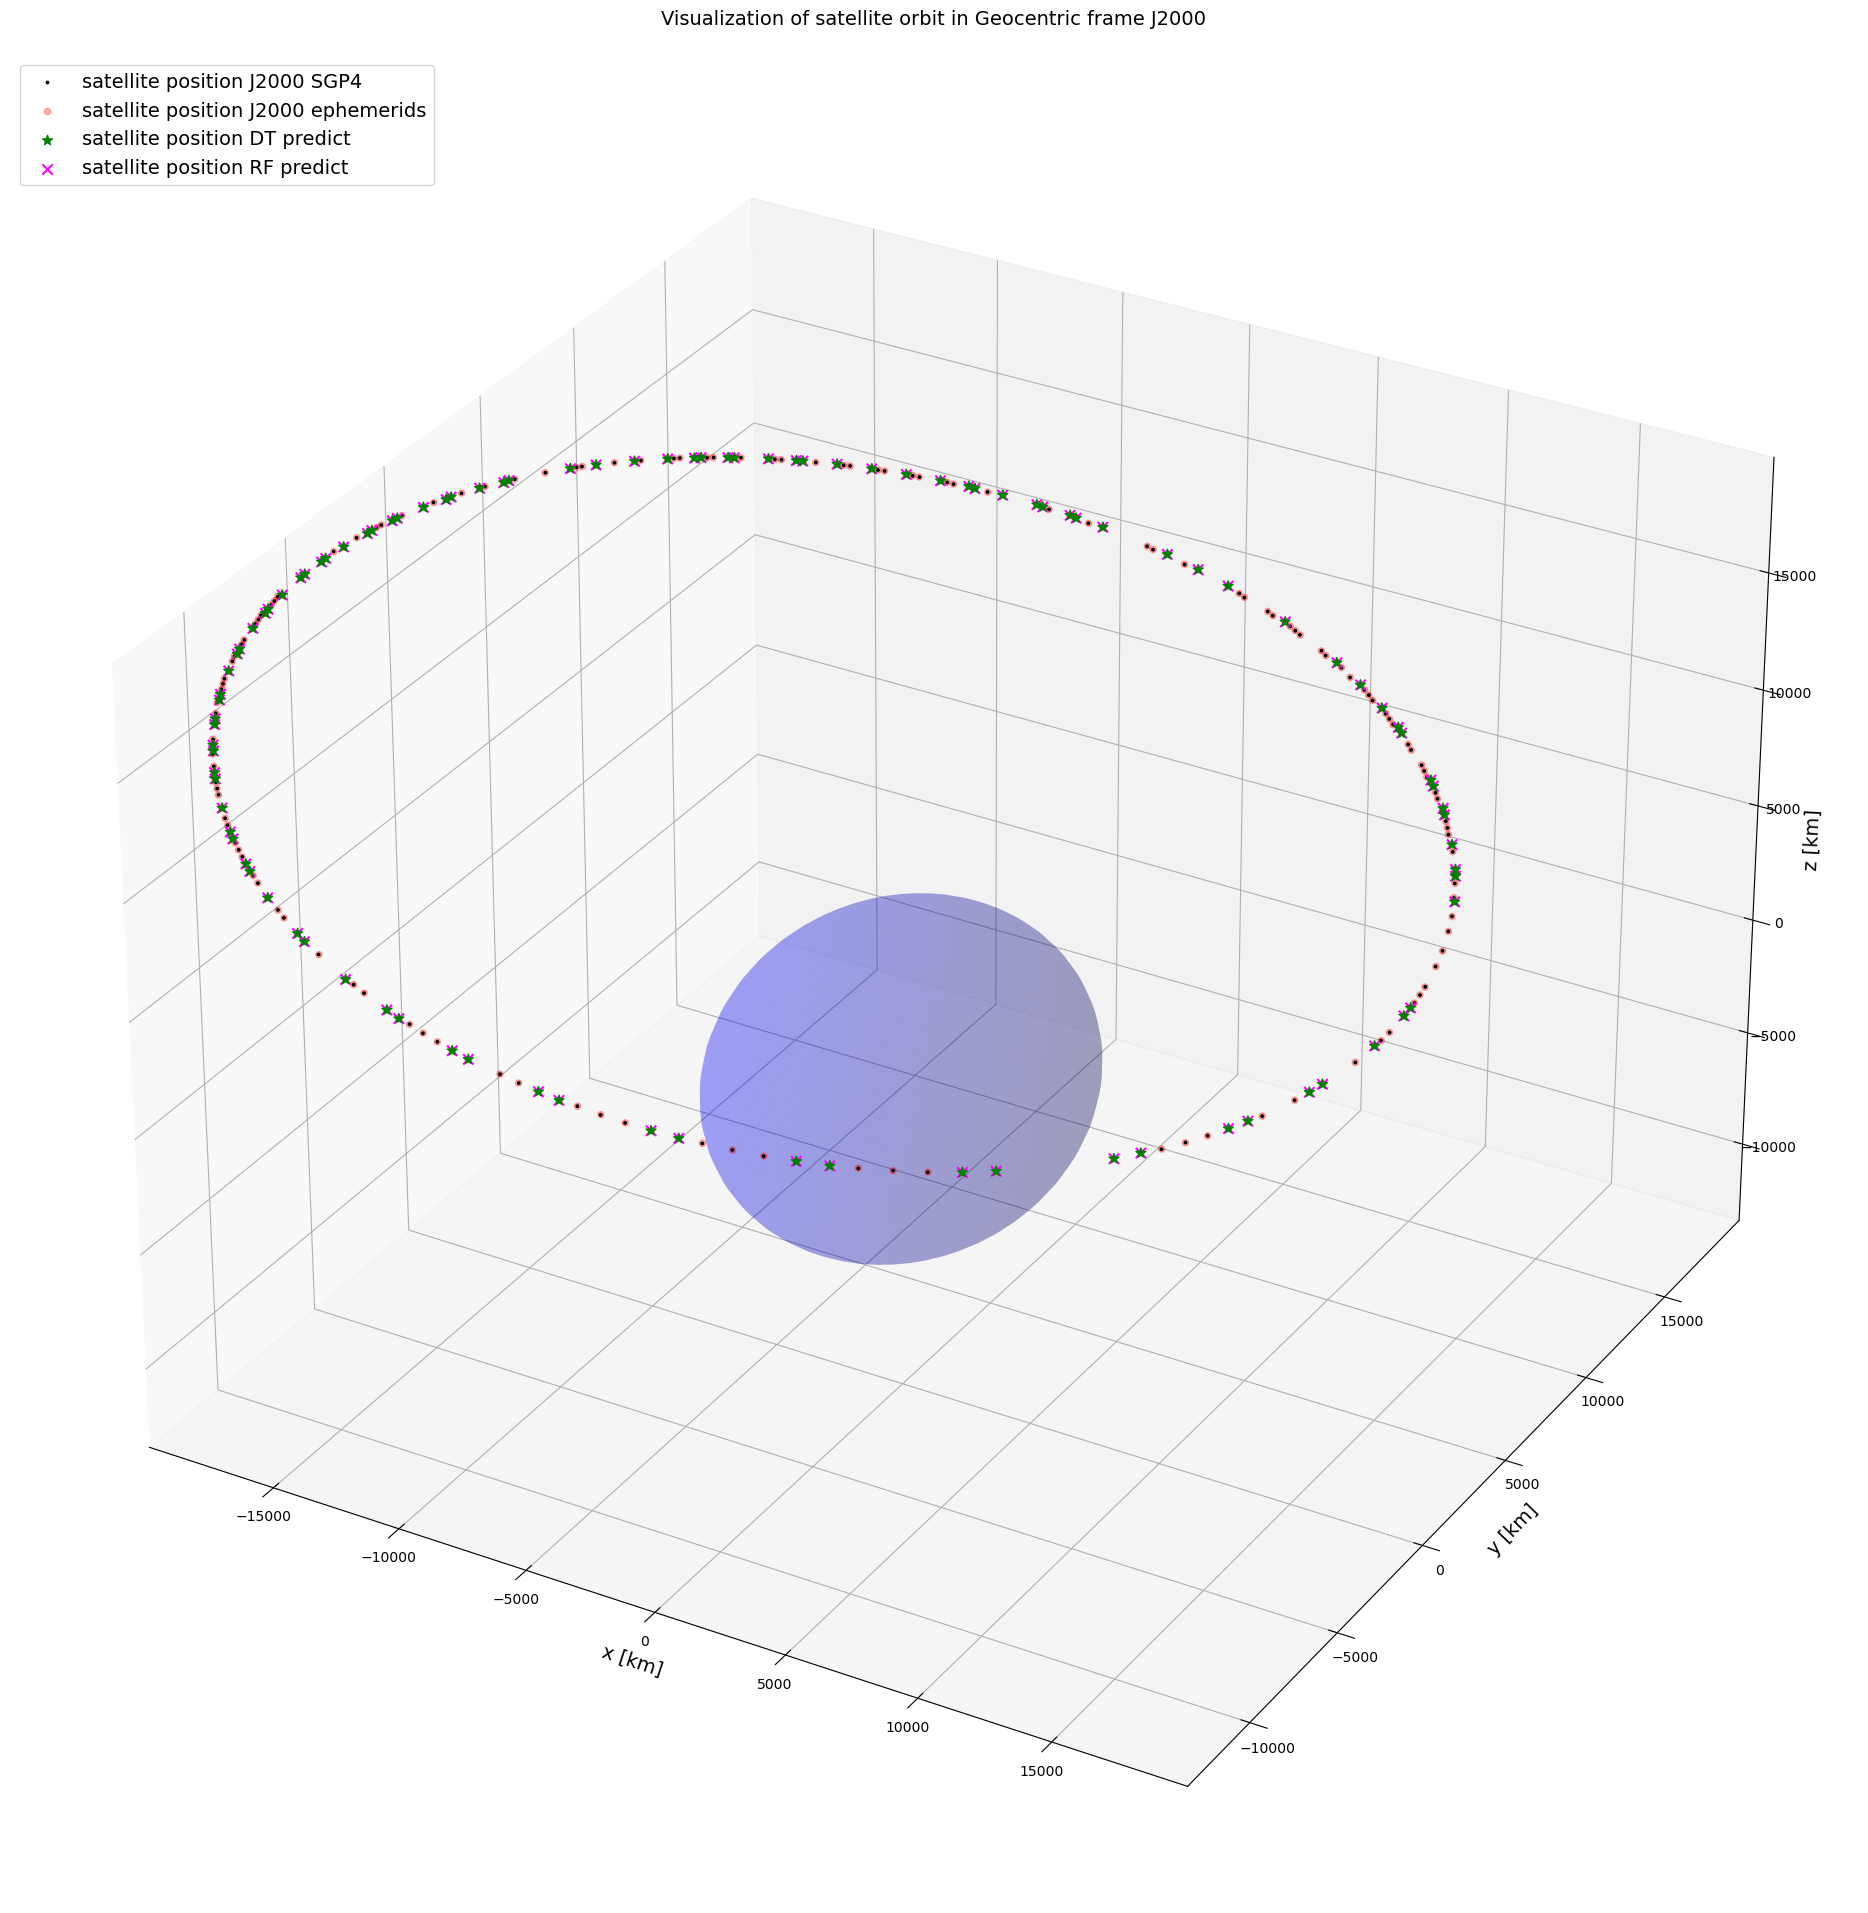

In [31]:
fig=plt.figure(figsize=(24,24))#Create 3D axes
ax = plt.axes(projection='3d')
plt.rcParams['font.size'] = '16'
r_Earth= 6400 #km
# making grid for Earth to visualize
NN = 50
phi = np.linspace(0, 2 * np.pi, NN)
theta = np.linspace(0, np.pi, NN)
theta, phi = np.meshgrid(theta, phi)
X_e = r_Earth * np.cos(phi) * np.sin(theta)
Y_e = r_Earth * np.sin(phi) * np.sin(theta)
Z_e = r_Earth * np.cos(theta)
# plotting Earth as a sphere wit radius of r_Earth
e_surf = ax.plot_surface(X_e, Y_e, Z_e, color='blue', alpha=0.2)
e_surf._facecolors2d = e_surf._facecolor3d
e_surf._edgecolors2d = e_surf._edgecolor3d
# plotting dynamics of earth LEO sat around Earth
ax.scatter(dataset['x_tle'][(38011-5739):32500],dataset['y_tle'][(38011-5739):32500],dataset['z_tle'][(38011-5739):32500],color="black",marker="o",s=3,alpha=1,label="satellite position J2000 SGP4")
ax.scatter(dataset['x'][(38011-5739):32500],dataset['y'][(38011-5739):32500],dataset['z'][(38011-5739):32500],color="red",s=20,alpha=0.3,label="satellite position J2000 ephemerids")
ax.scatter(y_pr3[:100,0],y_pr3[:100,1],y_pr3[:100,2],color="green",marker="*",s=55,alpha=1,label="satellite position DT predict"  )
ax.scatter(y_pr2[:100,0],y_pr2[:100,1],y_pr2[:100,2],color="magenta",marker="x",s=55,alpha=1,label="satellite position RF predict"  )
# axis labeling
ax.set_xlabel("x [km]",fontsize=14)
ax.set_ylabel("y [km]",fontsize=14)
ax.set_zlabel("z [km]",fontsize=14)
ax.set_title("Visualization of satellite orbit in Geocentric frame J2000\n",fontsize=14)
ax.legend(loc="upper left",fontsize=14)

ax.set_xlim3d(-3.*r_Earth, 3.*r_Earth)
ax.set_ylim3d(-2.*r_Earth, 3.*r_Earth)
ax.set_zlim3d(-2.*r_Earth, 3.*r_Earth)
plt.show()